In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Reinforcement Learning

## Session 05a: Control


## Frozen Lake with MC Control

    
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Import statements
import os
import gym
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from collections import defaultdict

import seaborn as sns

from time import sleep
from IPython.display import clear_output, display

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

 ## Load Frozen Lake Environment

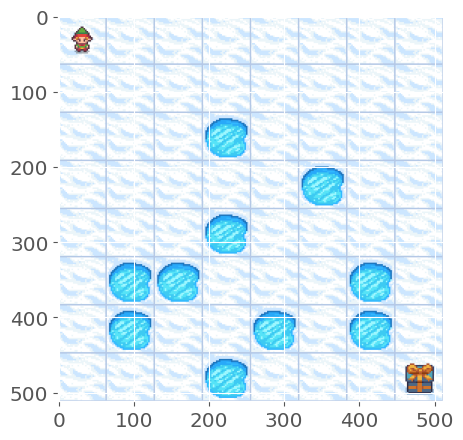

In [4]:
# Make the environment based on non-deterministic policy

env = gym.make('FrozenLake8x8-v1', render_mode='rgb_array')

env.reset(seed = RANDOM_STATE)

img = plt.imshow(env.render())

## Environment - FrozenLake

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 8 x 8 grid world. 
States $S$ are from 0 to 63

SFFFFFFF       (S: starting point, safe)<br>
FFFFFFFF       (F: frozen surface, safe)<br>
FFFHFFFF       (H: hole, fall to your doom)<br>
FFFFFHFF       (G: goal, where the frisbee is located)<br>
FFFHFFFF<br>
FHHFFFHF<br>
FHFFHFHF<br>
FFFHFFFG <br>

<img src='./images/Frozenlake8x8.png' style='width:400px;'>

In [5]:
GRID_SIZE = np.sqrt(env.observation_space.n).astype(np.int16)
GRID_SIZE

8

In [6]:
# Helper function to plot the grid

def fn_plot_heatmap(values, opt_policy):
    
    '''
    Args:
        values: np.array, size ( nS, ),
        opt_policy: np.array, size ( nS, ) 
    '''
    
    fig, axes = plt.subplots(1,2 )
    
    # Mapping of arrows against the policy
    act = [action_mappings[action] for action in opt_policy]
    
    # ravel state values and construct list of labels
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip ( act, values) ] ).reshape ( GRID_SIZE, GRID_SIZE )
 
    sns.heatmap(values.reshape ( GRID_SIZE, GRID_SIZE ), annot=labels, fmt="", cmap='RdYlGn', ax=axes[0])
    
    img = plt.imread('./images/Frozenlake8x8.png')
    
    ax = axes[1]
    
    ax.imshow(img)
    
    ax.set_xticks([])
    
    ax.set_yticks([])
    
    plt.show()

In [7]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


1 0.0 False False {'prob': 0.3333333333333333}


/home/pks/RL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


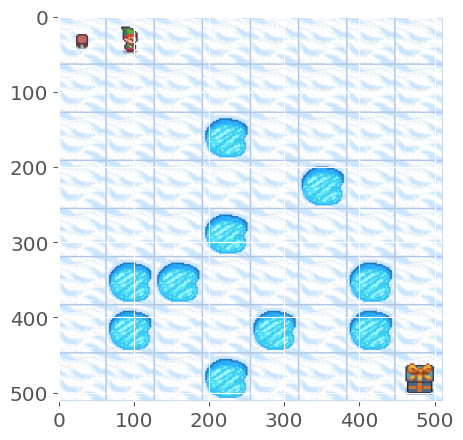

In [8]:
# Go right once (action = 2), we should go to the right but we did not!

env.reset()

action = 2

observation, reward, done, other, prob = env.step(action)

img = plt.imshow(env.render())

print (observation, reward, done, other, prob)

2 0.0 False False {'prob': 0.3333333333333333}


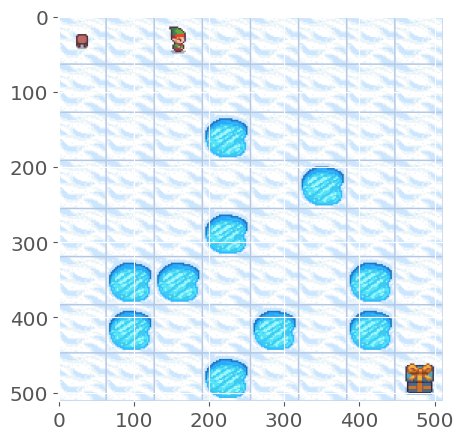

In [9]:
action = 2

observation, reward, done, other, prob = env.step(action)

img = plt.imshow(env.render())

print (observation, reward, done, other, prob)

In [10]:
# Define a random policy
def create_random_policy(env):
    '''
    Args:
        env: Environment object
    Return:
        policy: dictionary object of dicts

    @@ TBD: why do we need this
        Can we sample from env.action_space.sample()????
    '''
    policy = {}
    
    for key in range(0, env.observation_space.n): # for all states
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n # all actions are equally possible
        policy[key] = p
    return policy

# Define a Q ( S, A)
def create_state_action_dictionary(env, policy):
    '''
    Args:
        env: Environment object
        policy: dictionary object of dicts
    Return:
        Q : dictionary object of dicts

    @@ TBD: why do we need this
        Can we sample from env.action_space.sample()????
    '''
    Q = {}
    
    for key in policy.keys():
        
        Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
        
    return Q 

In [37]:
#  Helper function to display execution of run
def run_game(env, policy, display=False):
    
    env.reset()[0] # reset the environmnet
    
    episode = [] 
    
    finished = False
    
    while not finished:
        
        s = env.env.s # get current state
            
        if display:
            clear_output(True)
            env.render()
            sleep(0.1)

        timestep = []
        
        timestep.append(s) # create list of states
        
        n = random.uniform(0, sum(policy[s].values())) # Generate a number between 0 and sum for that state
        
        top_range = 0
        
        for prob in policy[s].items(): #make sure you are selecting for action as per random generated number
            
            top_range += prob[1]
            
            if n < top_range:
                
                action = prob[0]
                
                break   
        
        state, reward, finished, truncated, info =  env.step(action) # take action
        
        # Create an state, action, reward list
        timestep.append(action)
        
        timestep.append(reward)
        
        # append to the episode
        episode.append(timestep)
        
    if display:
        clear_output(True)
        env.render()
        sleep(0.05)
    
    return episode

def test_policy(policy, env):
    wins = 0
    r = 100
    for i in range(r):
        w = run_game(env, policy, display=False)[-1][-1]
        if w == 1:
            wins += 1
    return wins / r

In [39]:
# Unit testing
episode = run_game(env, create_random_policy(env))

episode

[[0, 2, 0.0],
 [0, 3, 0.0],
 [1, 0, 0.0],
 [1, 3, 0.0],
 [2, 3, 0.0],
 [2, 3, 0.0],
 [1, 3, 0.0],
 [0, 3, 0.0],
 [0, 2, 0.0],
 [8, 3, 0.0],
 [9, 2, 0.0],
 [1, 0, 0.0],
 [9, 1, 0.0],
 [17, 2, 0.0],
 [9, 2, 0.0],
 [1, 0, 0.0],
 [1, 3, 0.0],
 [2, 0, 0.0],
 [1, 3, 0.0],
 [2, 2, 0.0],
 [2, 2, 0.0],
 [2, 3, 0.0],
 [3, 3, 0.0],
 [2, 3, 0.0],
 [2, 1, 0.0],
 [10, 2, 0.0],
 [2, 2, 0.0],
 [3, 1, 0.0],
 [4, 3, 0.0],
 [3, 0, 0.0],
 [3, 1, 0.0],
 [4, 2, 0.0],
 [5, 0, 0.0],
 [4, 2, 0.0],
 [4, 3, 0.0],
 [5, 0, 0.0],
 [5, 0, 0.0],
 [13, 0, 0.0],
 [5, 0, 0.0],
 [4, 3, 0.0],
 [4, 1, 0.0],
 [12, 0, 0.0],
 [11, 1, 0.0],
 [10, 1, 0.0],
 [11, 2, 0.0],
 [12, 2, 0.0],
 [4, 3, 0.0],
 [3, 0, 0.0],
 [11, 1, 0.0],
 [10, 3, 0.0],
 [11, 2, 0.0],
 [3, 2, 0.0],
 [11, 0, 0.0]]

In [13]:
def monte_carlo_e_soft(env, episodes=100, policy=None, epsilon=0.01):
    
    # if there are no policy
    if not policy:
        
        policy = create_random_policy(env) 
    
    # Create Q (S, A)
    Q = create_state_action_dictionary(env, policy)
    
    # Collect returns in this
    returns = {}
    
    for _ in trange(episodes):
        
        
        G = 0 # Instantiate return for this state action pair
        
        episode = run_game(env=env, policy=policy, display=False) # get an episode
        
        for i in reversed(range(0, len(episode))): # start from end
            
            s_t, a_t, r_t = episode[i]
            
            state_action = (s_t, a_t)
            
            G += r_t # acumulate rewards
            
            if not state_action in [(x[0], x[1]) for x in episode[0:i]]:
                
                if returns.get(state_action):
                    
                    returns[state_action].append(G) # if this combination is present append to list
                
                else:
                    
                    returns[state_action] = [G]   # if not replace
                    
                Q[s_t][a_t] = sum(returns[state_action]) / len(returns[state_action])
                
                Q_list = list(map(lambda x: x[1], Q[s_t].items())) # convert to list
                
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                
                max_Q = random.choice(indices)
                
                A_star = max_Q
                
                for a in policy[s_t].items():
                    
                    if a[0] == A_star:
                        
                        policy[s_t][a[0]] = 1 - epsilon + (epsilon / abs(sum(policy[s_t].values())))
                    
                    else:
                        
                        policy[s_t][a[0]] = (epsilon / abs(sum(policy[s_t].values())))

    return policy, Q

In [14]:
policy, Q = monte_carlo_e_soft(env, episodes=50000)

100%|████████████████████████████████████| 50000/50000 [05:14<00:00, 158.95it/s]


In [15]:
test_policy(policy, env)

0.38

In [16]:
_ = run_game(env, policy)

### Creating State Value

Using policy and state action values, we can calculate state values

In [32]:
opt_pol = np.zeros(env.observation_space.n).astype(np.int16)

plot_grid = np.zeros(env.observation_space.n)

for state in range(env.observation_space.n): # looping through all states
    
    plot_grid[state] = 0
    
    opt_pol[state] = np.argmax(list(Q[state].values()))
    for action in range(env.action_space.n):

        plot_grid[state] += Q[state][action]*policy[state][action]

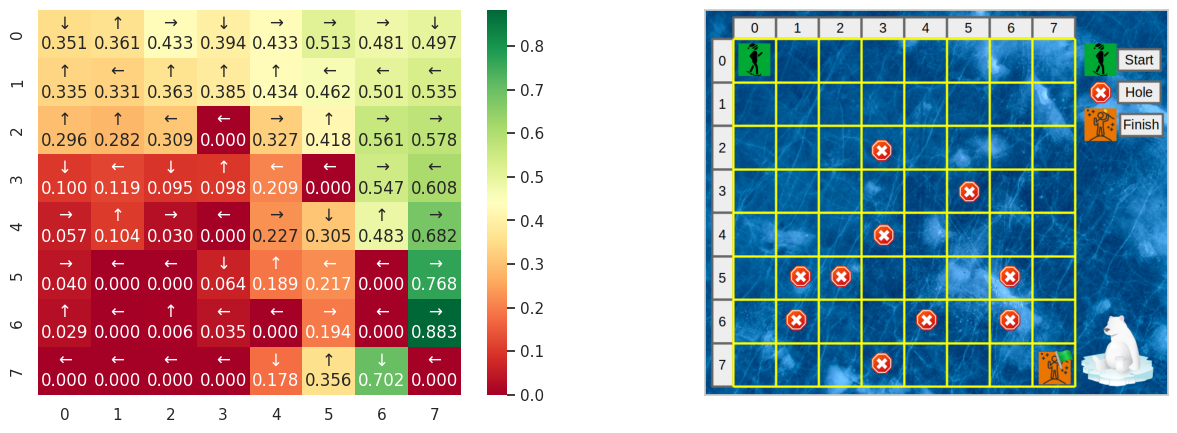

In [33]:
fn_plot_heatmap(plot_grid, opt_pol)

In [19]:
n_iteration = 1000

highscore = 0

data_row = []

for n_iter in trange(n_iteration):

    points = 0 # keep track of the reward each episode
    
    data_dict = {}
    
    for i_episode in range(20): # run 20 episodes
        
        observation, _ = env.reset()
        
        while True: # run until episode is done
            
            action = opt_pol[observation]
            
            observation, reward, done, truncated, info = env.step(action)
            
            points += reward
            
            if done:
                env.render()
                #print ('Iteration', n_iter, observation, reward, done, info)

                if points > highscore: # record high score
                    highscore = points
                break
                
    data_dict['run'] = n_iter
    
    data_dict['Points']=  points
    
    data_row.append(data_dict)

100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.71it/s]


In [20]:
# Dataframe for ease of plotting
results_df =  pd.DataFrame(data_row)

results_df.head()

,run,Points
0,0,11.0
1,1,13.0
2,2,12.0
3,3,14.0
4,4,11.0


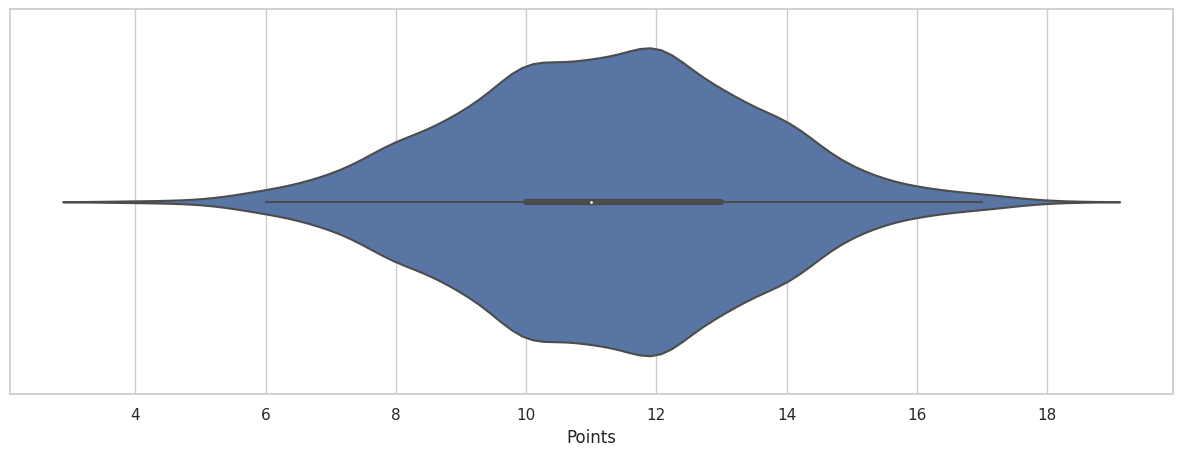

In [21]:
sns.set_theme(style="whitegrid")

ax = sns.violinplot(x=results_df["Points"])